Full pipeline for generating captions for Full Resolution Whole Slide Images (WSI).

The Pipeline is as follows:

1. Generate patches
2. Generate HIPT representations from these patches
3. Load pre-trained captioning model
4. Generate captions using in-built hugging face generate module

In [1]:
from transformers.utils import logging

logging.set_verbosity_error()
logger = logging.get_logger("transformers")

## 1. Generate patches

In [2]:
# adapted from CLAM: https://github.com/mahmoodlab/CLAM/
from gen_patch.create_patches_fp import patch_one_wsi

In [3]:
patch_size=4096
step_size=4096

wsi_full_path='/scratch/ss4yd/gtex_data_new/GTEX-13FLV-0326.svs'
save_dir='/home/ss4yd/nlp/tcga_testing/full_inference_pipeline/image_files/'
slide_id = wsi_full_path.split('/')[-1].split('.')[0]
print(slide_id)

patch_one_wsi(wsi_full_path=wsi_full_path, save_dir=save_dir, 
              patch_size=patch_size, step_size=step_size)

GTEX-13FLV-0326
Creating patches for:  GTEX-13FLV-0326 ...
Total number of contours to process:  2
Bounding Box: 27699 3776 18836 19489
Contour Area: 268852696.0
Extracted 20 coordinates
Bounding Box: 3488 3136 18916 21169
Contour Area: 244157072.0
Extracted 20 coordinates
stitch
start stitching GTEX-13FLV-0326
original size: 49799 x 28049
downscaled size for stiching: 3112 x 1753
number of patches: 40
patch size: 4096x4096 patch level: 0
ref patch size: (4096, 4096)x(4096, 4096)
downscaled patch size: 256x256
progress: 0/40 stitched
progress: 4/40 stitched
progress: 8/40 stitched
progress: 12/40 stitched
progress: 16/40 stitched
progress: 20/40 stitched
progress: 24/40 stitched
progress: 28/40 stitched
progress: 32/40 stitched
progress: 36/40 stitched
segmentation took 0.8628861904144287 seconds
patching took 0.15238094329833984 seconds
stitching took 0.2759437561035156 seconds


## 2. Generate HIPT representations from patches

Note that if CPU bound, extracting representations can take some time. If using GPU, this code only works if you have 2 cuda devices.

Here we have 2 NVIDIA A6000s and it takes around ~90 seconds to generate representations of size 256x384 for 46 4096x4096 patches created from the WSI from the ViT-256 and ViT-4096.

In [4]:
import torch
torch.cuda.get_device_name(0)

'NVIDIA RTX A6000'

In [5]:
# adapted from https://github.com/mahmoodlab/HIPT
from gen_reps.generate_256clsreps import generate256reps_onewsi,generate4kreps_onewsi
import os

In [6]:
generate256reps_onewsi(wsi_full_path, save_dir)

Take key teacher in provided checkpoint dict
Pretrained weights found at /home/ss4yd/vision_transformer/HIPT/HIPT_4K/Checkpoints/vit256_small_dino.pth and loaded with msg: _IncompatibleKeys(missing_keys=[], unexpected_keys=['head.mlp.0.weight', 'head.mlp.0.bias', 'head.mlp.2.weight', 'head.mlp.2.bias', 'head.mlp.4.weight', 'head.mlp.4.bias', 'head.last_layer.weight_g', 'head.last_layer.weight_v'])
SVS ID: GTEX-13FLV-0326
Number of patches: 40
Finished saving tensor..
generating reps took 53.215198278427124 seconds


In [7]:
generate4kreps_onewsi(wsi_full_path, save_dir)

# of Patches: 196
Loading Pretrained Local VIT model...
Done!
Finished saving tensor..
generating reps took 0.17805933952331543 seconds


## 3. Load pre-trained captioning model

In [8]:
from transformers import AutoModelForCausalLM, AutoTokenizer
from model_files.model_vit_bert3 import ViTConfigCustom, ViTModelCustom, CustomVEDConfig, CustomVisionEncoderDecoder
from model_files.training_script_vit_bert_3layers_bsgt1_v2 import LightningModel
from tqdm import tqdm
import os
import torch

# models: Encoder    
encoder = ViTModelCustom(config=ViTConfigCustom(hidden_size=576), pretrain_4k='vit4k_xs_dino', freeze_4k=True)

# decoder
decoder_model_name="emilyalsentzer/Bio_ClinicalBERT"
decoder = AutoModelForCausalLM.from_pretrained(decoder_model_name, is_decoder=True, add_cross_attention=True)
tokenizer = AutoTokenizer.from_pretrained(decoder_model_name)

# encoder decoder model
model=CustomVisionEncoderDecoder(config=CustomVEDConfig(),encoder=encoder, decoder=decoder)
model.config.decoder_start_token_id = tokenizer.cls_token_id
model.config.pad_token_id = tokenizer.pad_token_id

lightning_model = LightningModel(model, tokenizer, model_lr=1e-2)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

ckpt="/scratch/ss4yd/logs_only_vit_bert_fullexpv2_freezeFalse/my_model/version_23/checkpoints/epoch=5-val_loss=0.93-step=4254.00.ckpt"
lightning_model.load_state_dict(torch.load(ckpt,map_location=device)['state_dict'])
lightning_model=lightning_model.to(device)

## 4. Generate captions using in-built hugging face generate module

In [9]:
lightning_model.eval()
reps256_path = os.path.join(save_dir, 'reps/ft256', f'{slide_id}.pt')
reps4k_path = os.path.join(save_dir, 'reps/ft4k', f'{slide_id}.pt')

def generate_func(lm, reps256_path, reps4k_path, max_length=128, num_beams=2, do_sample=True):
    x256 = torch.load(reps256_path)
    x256mean = x256.mean(dim=1)
    x4k = torch.load(reps4k_path)

    pixel_values = torch.cat([x256mean, x4k], dim=1).unsqueeze(0)
    pixel_values=pixel_values.to(device)
    gencap=lm.model.generate(pixel_values, max_length=max_length, num_beams=num_beams, do_sample=do_sample,
                            return_dict_in_generate=True, output_attentions=True, early_stopping=True)

    return gencap

gencap = generate_func(lightning_model, reps256_path, reps4k_path, num_beams=1, do_sample=False)

decoded_cap=tokenizer.decode(gencap['sequences'][0])
gen_note=decoded_cap[6:decoded_cap.find('[SEP]')]
gen_note, decoded_cap

/home/ss4yd/.local/lib/python3.9/site-packages/transformers/generation/utils.py:1255: UserWarning: You have modified the pretrained model configuration to control generation. This is a deprecated strategy to control generation and will be removed soon, in a future version. Please use a generation configuration file (see https://huggingface.co/docs/transformers/main_classes/text_generation)
  warnings.warn(


('this is a liver tissue from a male patient and it has 2 pieces ; moderate congestion ',
 '[CLS] this is a liver tissue from a male patient and it has 2 pieces ; moderate congestion [SEP] [SEP] [SEP] [SEP] [SEP] [SEP]. [SEP]. [SEP]. [SEP]. [SEP]. [SEP]. this is a liver tissue from a male patient and it has 2 pieces ; mild macrovesicular steatosis [SEP] [SEP] [SEP] [SEP] [SEP] [SEP] [SEP] [SEP] [SEP] [SEP] [SEP] [SEP] [SEP] [SEP] [SEP] [SEP] [SEP] [SEP] [SEP] [SEP] [SEP] [SEP] [SEP] [SEP] [SEP] [SEP] [SEP] [SEP] [SEP] [SEP] [SEP] [SEP] [SEP] [SEP] [SEP] [SEP] [SEP] [SEP] [SEP] [SEP] [SEP] [SEP] [SEP] [SEP] [SEP] [SEP] [SEP] [SEP] [SEP] [SEP] [SEP] [SEP] [SEP] [SEP] [SEP] [SEP] [SEP]. this is a liver tissue from a male this is a')

In [14]:
gencap.keys()

odict_keys(['sequences', 'decoder_attentions', 'cross_attentions'])

## 5. Visualize results

In [10]:
def generate_cross_attentions(gencap):
    # ref: https://discuss.huggingface.co/t/t5-cross-attention-inconsistent-results/5520/2
    # From T5 documentation
    # Initial shape: Tuple (one element for each generated token) of tuples (one element for
    # each layer of the decoder) of torch.FloatTensor of shape
    # (batch_size, num_heads, generated_length, sequence_length).

    # combine all cross attention into one tensor
    x = [torch.stack(gencap['cross_attentions'][i]) for i in range(len(gencap['cross_attentions']))]
    x = torch.stack(x)
    # Shape: (nb_generated, nb_layer, (batch_size, num_heads, generated_length, sequence_length))
    # print(x.shape)

    x = x.transpose(1,0)
    # (nb_layer, nb_generated, batch_size, num_heads, generated_length, sequence_length)
    # print(x.shape)

    x = x.transpose(1,3)
    # (nb_layer, num_heads, batch_size, nb_generated, generated_length, sequence_length)
    # print(x.shape)

    x = torch.squeeze(x, 4)
    # (nb_layer, num_heads, batch_size, nb_generated, sequence_length)
    # print(x.shape)

    x = x.transpose(2, 1)
    # (nb_layer, batch_size, num_heads, nb_generated, sequence_length)
    # print(x.shape)
    return x

In [11]:
cross_attentions=generate_cross_attentions(gencap)
cross_attentions.shape

torch.Size([12, 1, 12, 127, 40])

In [12]:
mean_cross_attention=cross_attentions.mean(dim=2).mean(dim=0).squeeze(0)

In [15]:
tokens=tokenizer.convert_ids_to_tokens(gencap['sequences'][0])
print(len(tokens))
stop_index=tokens.index('[SEP]') # stop at first '[SEP]' token
tokens=tokens[0:stop_index+1]
tokens

128


['[CLS]',
 'this',
 'is',
 'a',
 'liver',
 'tissue',
 'from',
 'a',
 'male',
 'patient',
 'and',
 'it',
 'has',
 '2',
 'pieces',
 ';',
 'moderate',
 'congestion',
 '[SEP]']

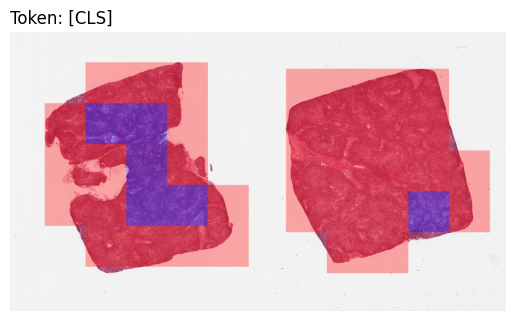

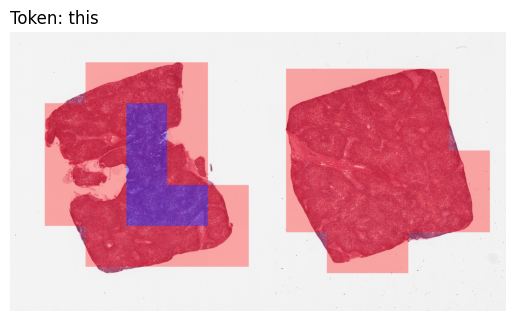

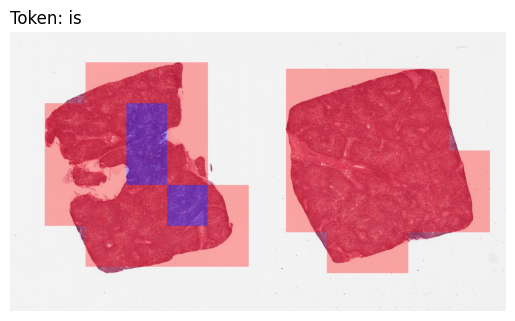

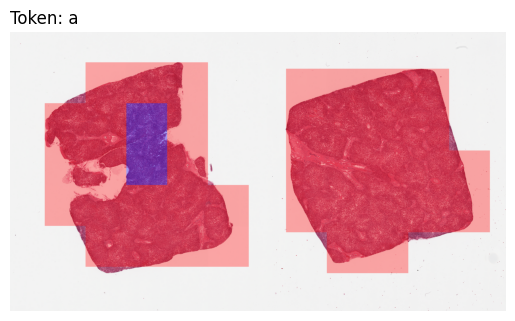

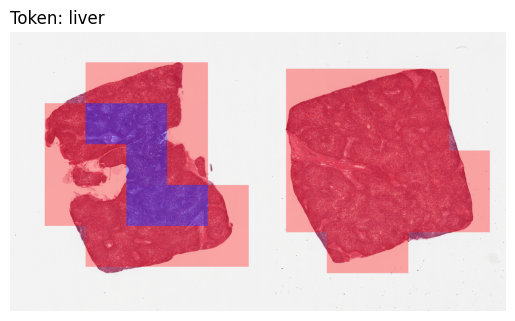

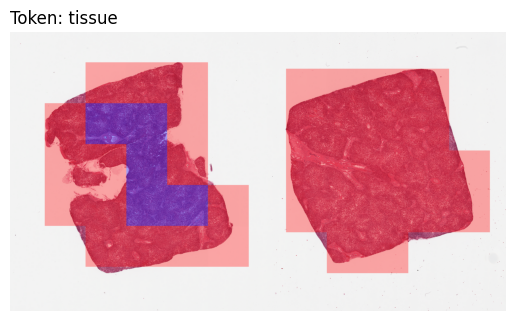

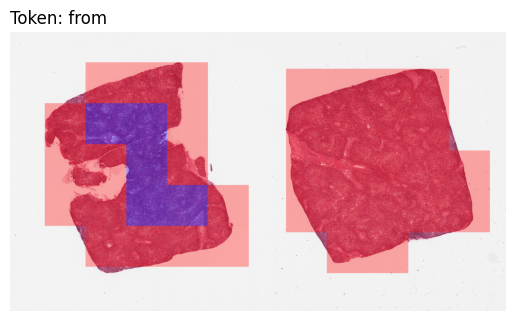

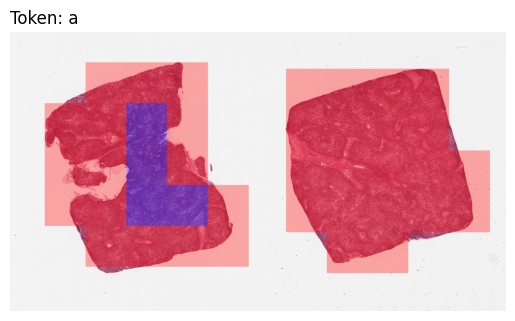

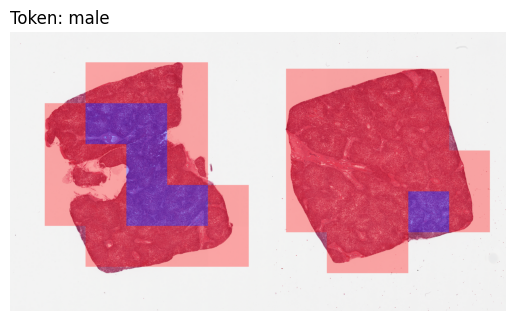

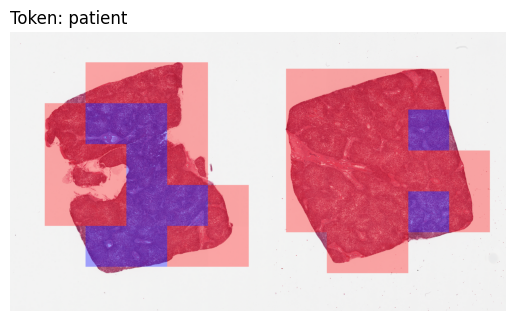

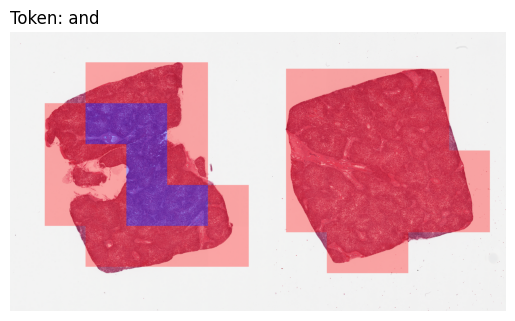

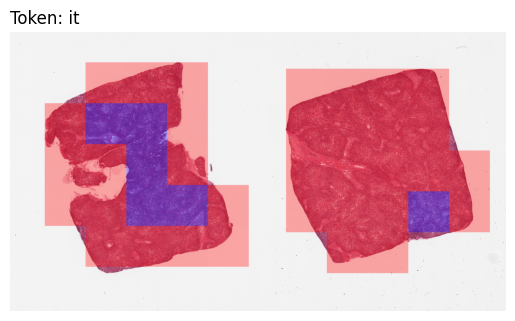

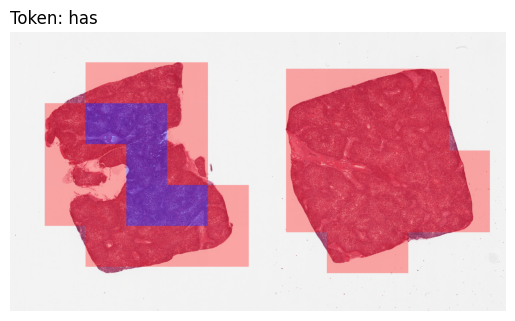

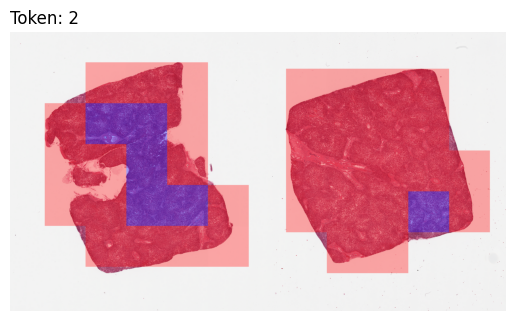

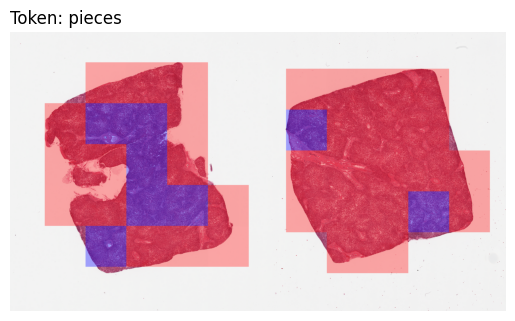

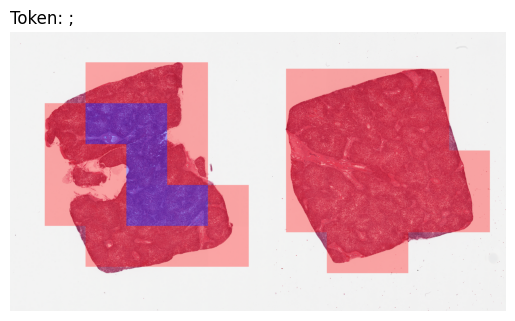

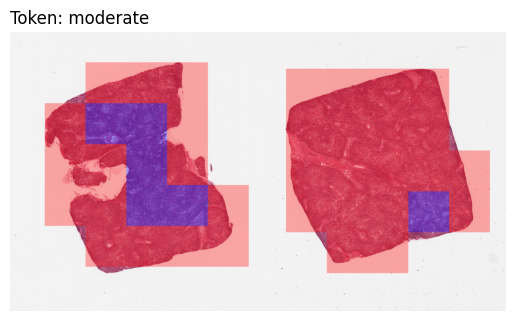

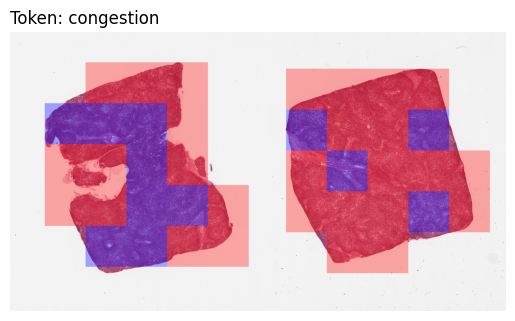

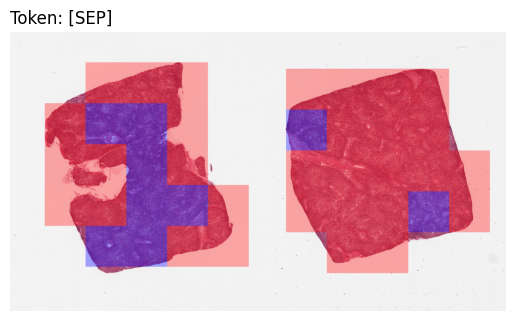

In [16]:
from attn_visualization import gen_attn_viz
import matplotlib.pyplot as plt
import numpy as np

patch_path = os.path.join(save_dir, 'patches', f'{slide_id}.h5')

# create attn_viz save directory
os.makedirs(os.path.join(save_dir, 'attn_viz'), exist_ok=True)

for i in range(len(tokens)):
    token = tokens[i]
    attentions = mean_cross_attention[i,:].cpu().numpy()
#     print(attentions)
    attentions=attentions/np.max(attentions)
#     print(attentions)
    attentions=np.array([x if x>0.99 else 0 for x in attentions])
#     print(attentions)
    sup_img=gen_attn_viz(wsi_full_path, patch_path, attentions, )
#     plt.figure(figsize=(20,8))
    plt.imshow(sup_img, cmap='jet')
    plt.title(f'Token: {token}',loc='left')
    # plt.text(0, -300, f'Actual Note: {actual_text}', fontsize=10)
#     plt.text(0, -200, f'Generated Note: {gen_note}', fontsize=10)
#     plt.colorbar(label='Attention scale',ticks=[])
    plt.axis('off')
#     plt.savefig(os.path.join(save_dir,'attn_viz', f'{slide_id}.png'), bbox_inches='tight')
    plt.show()